## Background / Motivation

Chicago is often deemed one of the most dangerous cities in the United States, and people are typically concerned with this issue when visiting or living in the city. As the four of us are students at Northwestern—in close proximity with Chicago—we frequent the city ourselves, and have personally witnessed crimes committed. For example, on the Red Line, a common mode of transportation for many Chicago residents and tourists, there are many visible crimes that scare people away from using the subway. 
Therefore, we were interested in analyzing crimes in Chicago in order to see which types of crimes we should be more vigilant of, or where in Chicago we should practice extra caution. These analyses are crucial to our safety and the safety of others like us, who share similar experiences. Additionally, police inequality or inefficient allocation of resources in policing has been a prevalent issue in the United States recently, so we wanted to explore potential areas of disparity. 


## Problem statement 

1. Alyssa's question looks at how crime characteristics are distributed throughout the day. At various hours of the day, it is expected that these characteristics will vary. I wanted to know which types of crimes are most common in the day-time vs. night-time, where crimes are commonly committed, and whether or not they are violent.  

2. Grace Chang's question examines theft, the most common type of crime, accounting for around 23% of total crimes, in further detail. I was interested in how theft was distributed across the various community areas of Chicago (e.g. The Loop), and how the population density of these areas relates to their respective theft rates. 

3. Grace Shao's question explores the most dangerous stations and community areas to ride the CTA in. I wanted to know the typical profiles of CTA crimes, specifically, where they are committed, whether they are committed on the train or platform, and which time of day to avoid certain stations. 

4. Paisley's question examines associations between the proportion of crimes that were arrested and the location in the city of Chicago, particularly in regards to police districts. How does the arrest proportion fluctuate depending on what part of the city the crime occurs in?


## Data sources

#### Primary Dataset:
To conduct our analysis, our primary dataset was Chicago crime data for 2022 as reported by the city of Chicago: https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp 

The data reports 239,043 observations of crimes in the city of Chicago (at the time of download, as this data is being updated to this day), and information about the crime such as its location, time/date, and whether or not the crime resulted in arrest. 

#### Supporting datasets include:
-  Chicago community areas by numeric code, population, area, and population density: https://en.wikipedia.org/wiki/Community_areas_in_Chicago 
    - Since the original dataset includes the numeric code of the community areas, to make our analysis more usable and readable, we merged the two datasets to include community area names. 

* IUCR codes https://data.cityofchicago.org/widgets/c7ck-438e 
    * Used in Alyssa’s analysis solely as reference to find violent crime type IUCR codes but not actually merged with data.

- CTA stations coordinates: https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme 
    - The latitude and longitude columms are used to find the nearest subway station of each crime.

* Police sentiment data via the city of Chicago: https://data.cityofchicago.org/Public-Safety/Police-Sentiment-Scores/28me-84fj/data
    * This dataset is a compilation of collected survey data about residents’ feeling towards police based on their responses to 4 questions:
        * Overall score for the Safety question: When it comes to the threat of crime, how safe do you feel in your neighborhood? (Level of safety from 0-10)
        * Overall score for the Listen question: How much do you agree with this statement? The police in my neighborhood listen to and take into account the concerns of local residents.” (Level of agreement from 0-10) 
        * Overall score for the Respect question: “How much do you agree with this statement? The police in my neighborhood treat local residents with respect.” (Level of agreement from 0-10)
        * Overall score for the Trust question: “How much do you agree with this statement? The police in my neighborhood listen to and take into account the concerns of local residents.” (Level of agreement from 0-10)


## Stakeholders
Our primary purpose is to help stakeholders understand crime in the city of Chicago. This understanding helps general parties make better choices to promote public and personal safety.

* Chicago residents/visitors: Residents and visitors will benefit from our analysis by using our recommendations to more safely navigate the city and transit stations and make housing decisions. 

* Police force: For the police force, we hope our analysis can give them direction on how to better serve and satisfy communities across districts and determine where to focus resources to create a safer Chicago. 


## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

In [2]:
#| echo: false
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [4]:
#| echo: false
raw_crime_data = pd.read_csv("crimes_-_2022.csv")
raw_crime_data['Date'] = raw_crime_data['Date'].apply(pd.to_datetime)

In [5]:
#| echo: false
time_data = raw_crime_data.dropna(subset = ['Location Description'])
theft_data = raw_crime_data.loc[(raw_crime_data['Primary Type'] == 'THEFT'), :]
community_areas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
community_areas = community_areas[0]
community_areas.columns = [col[0] for col in community_areas.columns]
community_areas.columns = ["No.", "Community Name", "Population", "Area (sqmi)", "Area (sqkm)", "Density (sqmi)", "Density (sqkm)"]

theft_data.loc[:,'Community Area'] = theft_data['Community Area'].apply(lambda x: f'{int(x):02d}' if isinstance(x, (int, str)) and str(x).isdigit() else x)
theft_data['Community Area'].value_counts().head(6) # Checking that the single digit codes were indeed converted to double digit format

theft_data.loc[:,'Community Area'] = theft_data['Community Area'].astype(str)
theft_community_data = theft_data.merge(community_areas, left_on = 'Community Area', right_on = 'No.', how = 'left')
theft_community_data['Community Name'] = theft_community_data['Community Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

arrest_data = raw_crime_data.copy()
arrest_data['Side'] = arrest_data.District
arrest_data['Side'] = arrest_data['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})

arrest_data = arrest_data.loc[arrest_data['District'] != 31, :]

# read sentiments data
sentiments = pd.read_csv('Police_Sentiment_Scores.csv')

# convert start date to datetime, subset only the values from 2022

sentiments['START_DATE'] = pd.to_datetime(sentiments['START_DATE'])
sentiments['START_DATE'] = sentiments['START_DATE'].map(lambda x: True if x.year == 2022 else False)
sentiments_2022 = sentiments.loc[sentiments['START_DATE'] == True, :]

# also subset only the general columns
sentiments_2022 = sentiments_2022.loc[:, ['DISTRICT', 'SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN']]

crimesCTA = raw_crime_data.loc[raw_crime_data['Location Description'].apply(lambda x: 'CTA' in str(x) and 'CTA BUS' not in str(x) 
                                                            and 'CTA PARKING LOT / GARAGE / OTHER PROPERTY' not in str(x)), :]

# Drop NA location values (longitude and latitude)
numberRows = crimesCTA.shape[0]
numberLongitudeNA = crimesCTA['Longitude'].isna().sum()
numberLatitudeNA = crimesCTA['Latitude'].isna().sum()

crimesCTA.dropna(subset=['Longitude'], inplace=True)
crimesCTA.dropna(subset=['Latitude'], inplace=True)

# Add a column with the names of the community areas instead of just the number
communityAreas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
communityAreas = communityAreas[0]
communityAreas.columns = [col[0] for col in communityAreas.columns]
communityAreas = communityAreas.iloc[:-1, [0,1]]
communityAreas.rename(columns={'No.': 'Community Area'}, inplace=True)
communityAreas.head()

crimesCTA['Community Area'] = crimesCTA['Community Area'].astype('int64')
communityAreas['Community Area'] = communityAreas['Community Area'].astype('int64')
crimesCTA = pd.merge(crimesCTA, communityAreas, on='Community Area', how='inner')
crimesCTA['Name'] = crimesCTA['Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

FileNotFoundError: [Errno 2] No such file or directory: 'Police_Sentiment_Scores.csv'

In [6]:
#| echo: false
describeDataset = raw_crime_data.loc[:, ['Year', 'Latitude', 'Longitude']].describe()
hour = raw_crime_data.Date.dt.hour.describe().to_frame()
describeDataset['Hour'] = hour
sentimentsDescribe = sentiments_2022.describe().drop(columns = 'DISTRICT')
theft_describe = theft_community_data.loc[:, 'Density (sqkm)'].describe().to_frame()
describeDataset['Density (sqkm)'] = theft_describe
describeDataset = pd.concat([describeDataset, sentimentsDescribe], axis=1)
describeDataset.rename(columns={'SAFETY': 'Safety Score', 'TRUST': 'Trust Score', 'T_RESPECT': 'Respect Score', 'T_LISTEN': 'Listening Score', 'Density (sqkm)': 'Population Density'}, inplace=True)

NameError: name 'sentiments_2022' is not defined

Below is a table of all of the continuous variables we used in our analysis, including variables from supporting datasets.

In [67]:
#| echo: false
describeDataset

,Year,Latitude,Longitude,Hour,Population Density,Safety Score,Trust Score,Respect Score,Listening Score
count,239043.0,234936.000000,234936.000000,239043.000000,54845.000000,1164.000000,1164.000000,1164.000000,1164.000000
mean,2022.0,41.845596,-87.668599,12.317633,6984.499435,57.442328,57.462148,58.680120,56.244296
std,0.0,0.088833,0.061009,6.985090,3602.179700,5.389730,6.707499,7.096675,6.634690
min,2022.0,36.619446,-91.686566,0.000000,388.360000,33.980000,38.040000,39.310000,35.040000
25%,2022.0,41.769150,-87.710149,7.000000,4405.730000,54.137500,52.427500,53.540000,51.525000
50%,2022.0,41.862981,-87.661469,13.000000,6226.000000,57.470000,57.410000,58.420000,56.360000
75%,2022.0,41.909017,-87.626402,18.000000,9516.370000,61.380000,61.890000,63.667500,60.620000
max,2022.0,42.022548,-87.524532,23.000000,14863.580000,71.110000,77.100000,78.850000,75.630000


The following are the categorical variables included in the main dataset:
* IUCR
* Primary Type
* Description
* Location Description
* Arrest
* District
* Community Area
* Latitude
* Longitude

## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

In [103]:
#| echo: false
print('The number of unique IUCR values is',
      ' ',
      raw_crime_data['IUCR'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['IUCR'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['IUCR'].value_counts().head(3), '\n', sep='')

print('The number of unique Primary Type values is',
      ' ',
      raw_crime_data['Primary Type'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Primary Type'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Primary Type'].value_counts().head(3), '\n', sep='')

print('The number of unique Description values is',
      ' ',
      raw_crime_data['Description'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Description'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Description'].value_counts().head(3), '\n', sep='')

print('The number of unique Location Description values is',
      ' ',
      raw_crime_data['Location Description'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Location Description'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Location Description'].value_counts().head(3), '\n', sep='')

print('The number of unique Arrest values is',
      ' ',
      raw_crime_data['Arrest'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Arrest'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Arrest'].value_counts().head(3), '\n', sep='')

print('The number of unique District values is',
      ' ',
      raw_crime_data['District'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['District'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['District'].value_counts().head(3), '\n', sep='')

print('The number of unique Community Areas values is',
      ' ',
      raw_crime_data['Community Area'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Community Area'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Community Area'].value_counts().head(3), '\n', sep='')

print('The number of unique Latitude values is',
      ' ',
      raw_crime_data['Latitude'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Latitude'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Latitude'].value_counts().head(3), '\n', sep='')

print('The number of unique Longitude values is',
      ' ',
      raw_crime_data['Longitude'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Longitude'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Longitude'].value_counts().head(3), '\n', sep='')

print('The number of unique theft_community_data[Community Name] values is',
      ' ',
      theft_community_data['Community Name'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      theft_community_data['Community Name'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      theft_community_data['Community Name'].value_counts().head(3), '\n', sep='')

The number of unique IUCR values is 304 and the number of missing values is 0. The top three most frequent occurrences are:
0810    20096
0820    18863
0486    18679
Name: IUCR, dtype: int64

The number of unique Primary Type values is 31 and the number of missing values is 0. The top three most frequent occurrences are:
THEFT              54845
BATTERY            40925
CRIMINAL DAMAGE    27242
Name: Primary Type, dtype: int64

The number of unique Description values is 284 and the number of missing values is 0. The top three most frequent occurrences are:
SIMPLE            27207
OVER $500         20096
$500 AND UNDER    18863
Name: Description, dtype: int64

The number of unique Location Description values is 134 and the number of missing values is 881. The top three most frequent occurrences are:
STREET       67630
APARTMENT    45596
RESIDENCE    30470
Name: Location Description, dtype: int64

The number of unique Arrest values is 2 and the number of missing values is 0. The top thre

In [104]:
# Explain how each individual did their data cleaning

## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

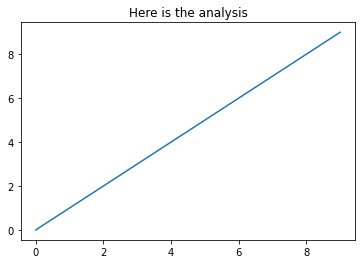

In [10]:
#| echo: false
import matplotlib.pyplot as plt
plt.plot(range(10));

In [9]:
#| echo: false
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]

sns.set_palette(sns.color_palette(colors))

### Analysis 1
*By \<Alyssa Shou>*

For my question on how crime type varies throughout the day, I started by graphing a full distribution of the number of crimes per hour. Based on this line graph, I saw that there are peaks at 12 am and 12 pm, so I used these two hours as parts of the dataset to specifically analyze.

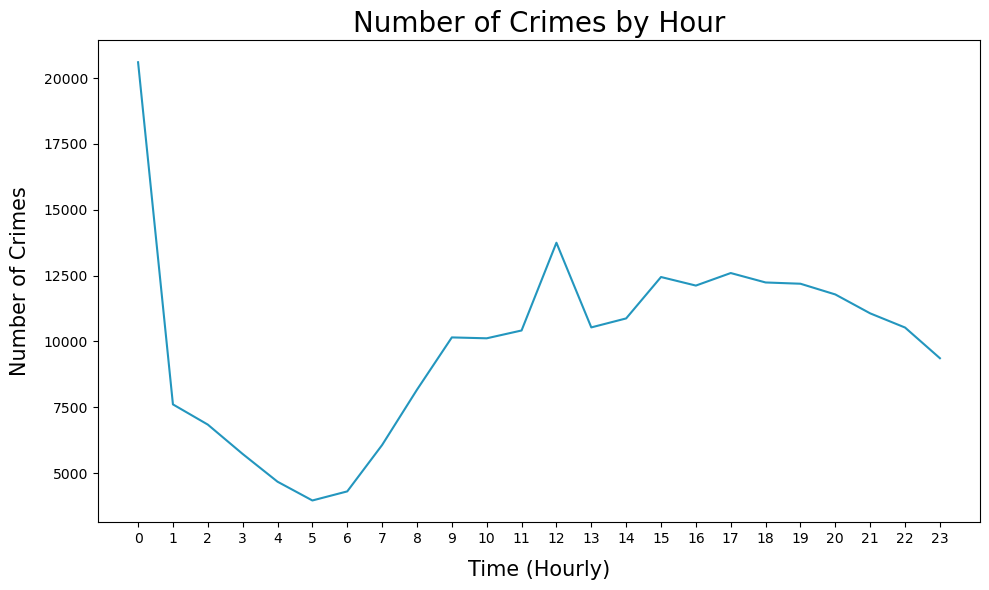

In [7]:
#| echo: false
# Round times down to nearest hour
time_data['hourly_time'] = time_data['Date'].dt.floor('H').dt.time

crime_counts = time_data['hourly_time'].value_counts().sort_index()
crime_counts = crime_counts.to_frame(name = 'Count').reset_index()

plt.figure(figsize=(10, 6))
bx = sns.lineplot(x= crime_counts.index, y=crime_counts.Count, color = "#2396be")
step = len(crime_counts.index) // 24 
plt.xticks(range(0, len(crime_counts.index), step))
plt.xlabel('Time (Hourly)', fontsize = 15, labelpad=10)
plt.ylabel('Number of Crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Hour', fontsize = 20)
plt.tight_layout()
plt.show()

I was also interested in analyzing rush hour time frames. Morning rush hour is ....

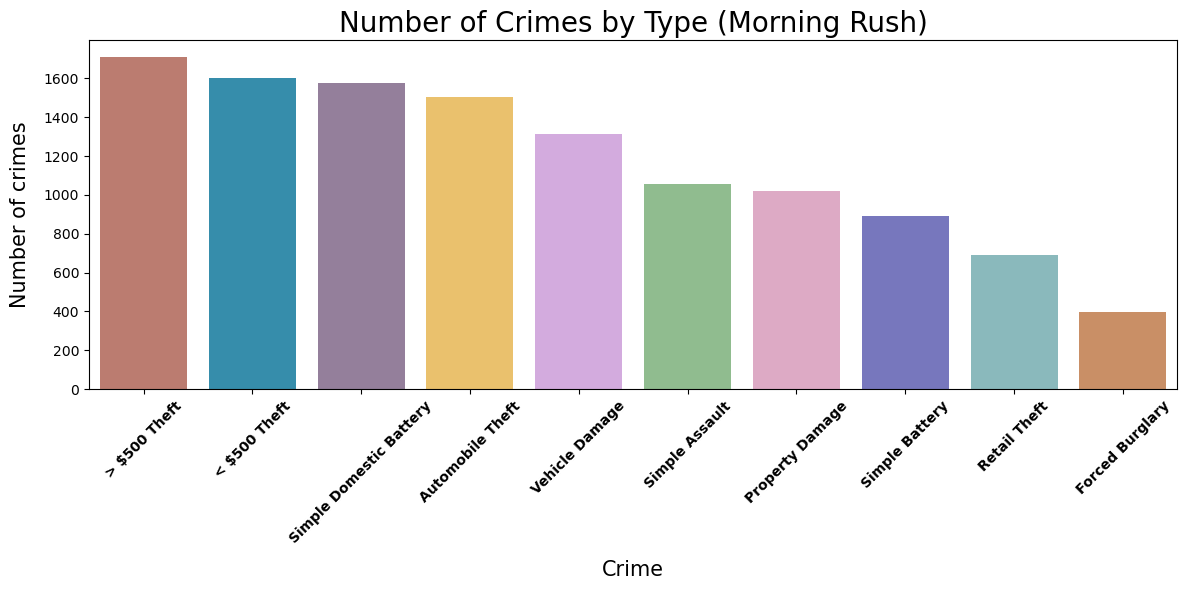

In [10]:
#| echo: false
morning_rush = time_data.loc[(time_data['Date'].dt.hour >= 6) & (time_data['Date'].dt.hour < 9)]
combination_mr = morning_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_mr = combination_mr.sort_values(by = 'Count', ascending = False).head(10)
combination_mr['Type'] = combination_mr['Primary Type'] + " " + combination_mr['Description']
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_mr.Type, y = combination_mr.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Automobile Theft', 
                             'Vehicle Damage', 'Simple Assault', 'Property Damage', 'Simple Battery', 
                             'Retail Theft', 'Forced Burglary'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Morning Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
plt.tight_layout()
plt.show()

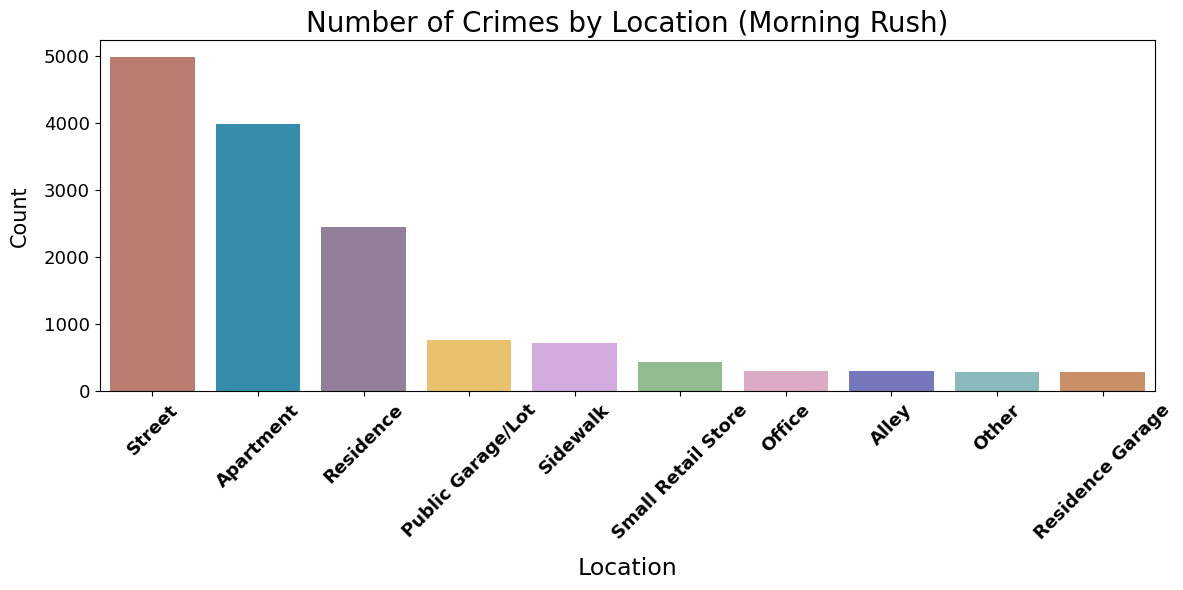

In [11]:
#| echo: false
mr_locations = morning_rush['Location Description'].value_counts().head(10)
locations_mr = mr_locations.to_frame(name = 'Count').reset_index()
#barplot of crime locations
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_mr.index, y = locations_mr.Count, palette = colors)
plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Street', 'Apartment', 'Residence', 'Public Garage/Lot', 
                             'Sidewalk', 'Small Retail Store',  'Office', 'Alley', 'Other', 
                             'Residence Garage'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Morning Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold', fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

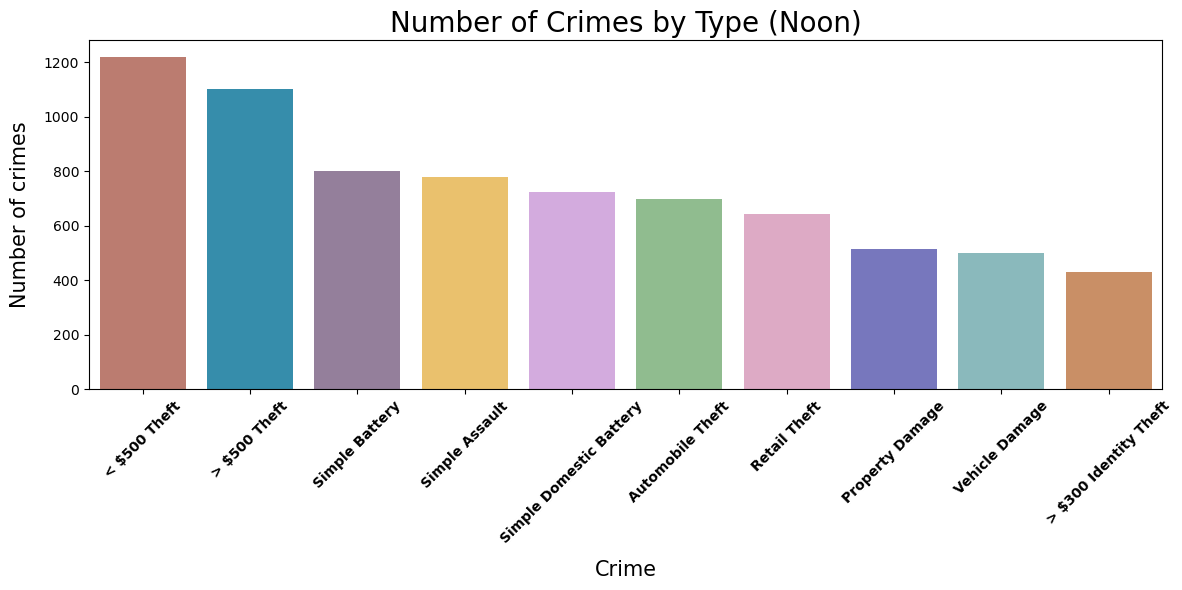

In [15]:
#| echo: false
noon = time_data.loc[time_data['Date'].dt.hour == 12]
combination_noon = noon.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_noon = combination_noon.sort_values(by = 'Count', ascending = False).head(10)
combination_noon['Type'] = combination_noon['Primary Type'] + " " + combination_noon['Description']
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_noon.Type, y = combination_noon.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['< $500 Theft', '> $500 Theft', 'Simple Battery', 'Simple Assault', 
                             'Simple Domestic Battery', 'Automobile Theft', 'Retail Theft', 'Property Damage', 
                             'Vehicle Damage', '> $300 Identity Theft'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Noon)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
plt.tight_layout()
plt.show()

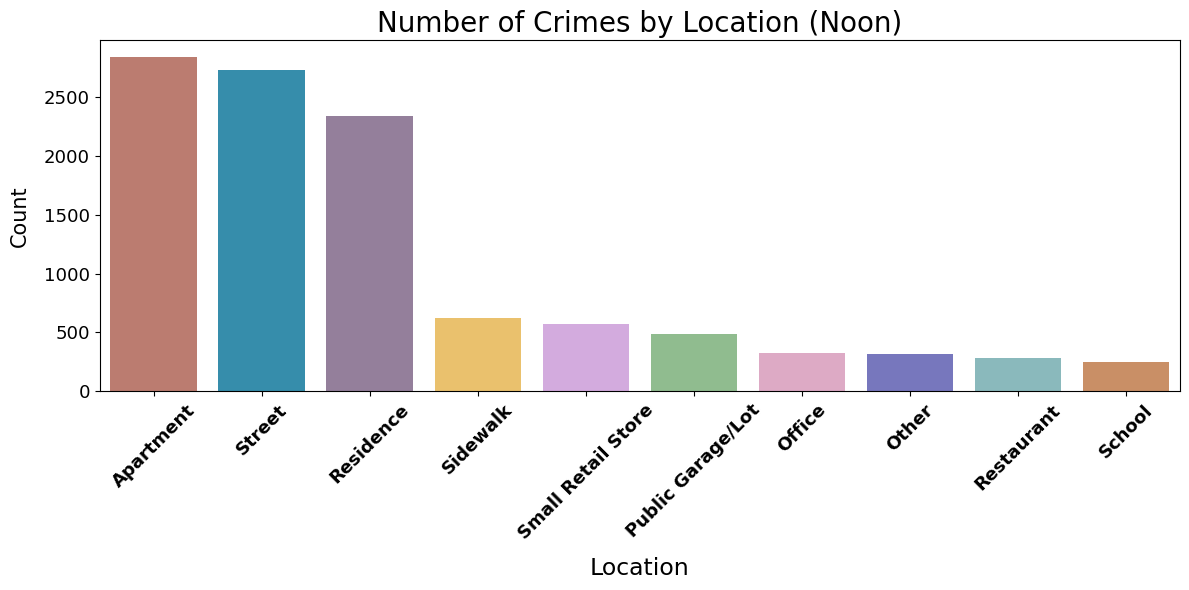

In [14]:
#| echo: false
noon_locations = noon['Location Description'].value_counts().head(10)
locations_noon = noon_locations.to_frame(name = 'Count').reset_index()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_noon.index, y = locations_noon.Count, palette = colors)
plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Apartment', 'Street', 'Residence', 'Sidewalk', 
                            'Small Retail Store', 'Public Garage/Lot', 'Office', 'Other', 
                            'Restaurant', 'School'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Noon)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold', fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

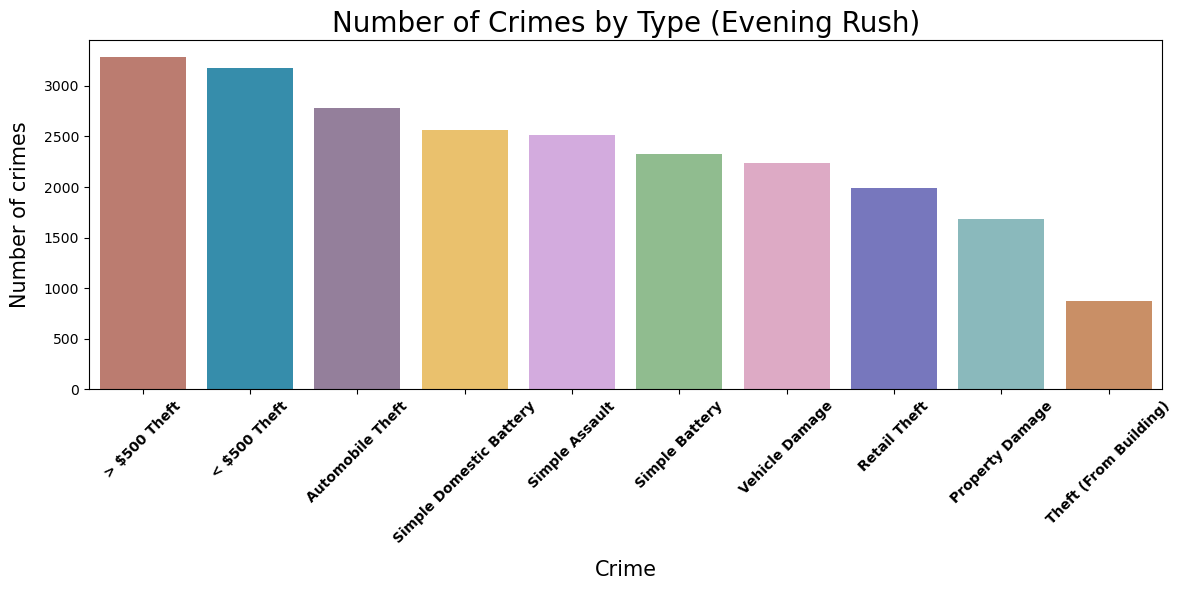

In [16]:
#| echo: false
evening_rush = time_data.loc[(time_data['Date'].dt.hour >= 16) & (time_data['Date'].dt.hour < 19)]
combination_er = evening_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_er = combination_er.sort_values(by = 'Count', ascending = False).head(10)
combination_er['Type'] = combination_er['Primary Type'] + " " + combination_er['Description']
#barplot of crime types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_er.Type, y = combination_er.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['> $500 Theft', '< $500 Theft', 'Automobile Theft', 'Simple Domestic Battery',
                             'Simple Assault', 'Simple Battery', 'Vehicle Damage', 
                             'Retail Theft', 'Property Damage', 'Theft (From Building)'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Evening Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
plt.tight_layout()
plt.show()

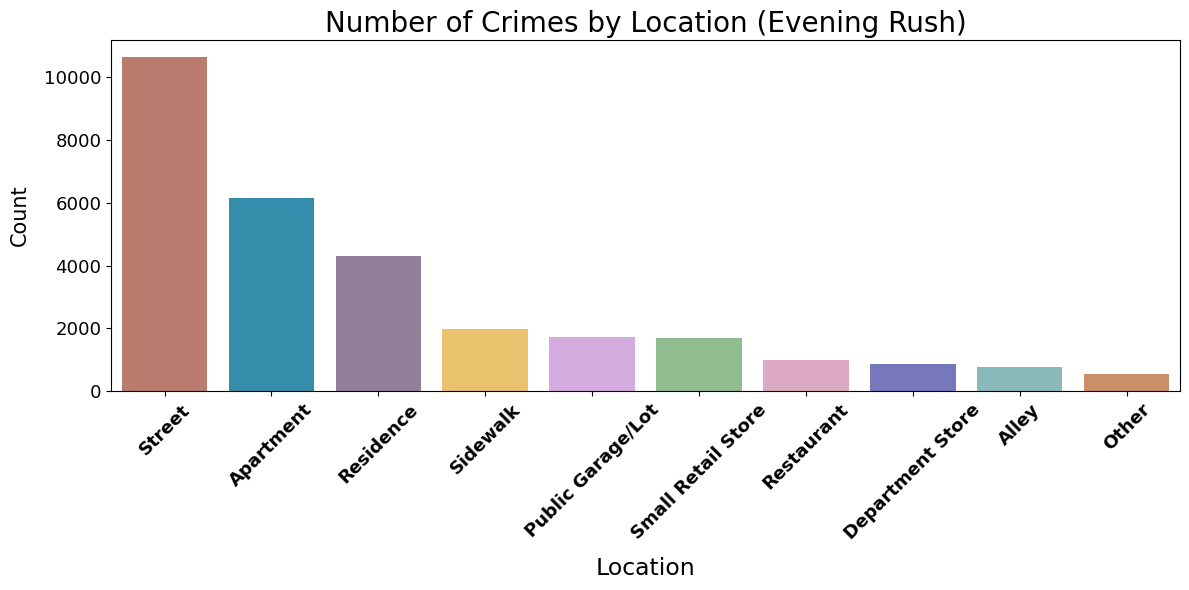

In [17]:
#| echo: false
er_locations = evening_rush['Location Description'].value_counts().head(10)
locations_er = er_locations.to_frame(name = 'Count').reset_index()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_er.index, y = locations_er.Count, palette = colors)
plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Street', 'Apartment', 'Residence', 'Sidewalk', 'Public Garage/Lot', 
                             'Small Retail Store', 'Restaurant', 'Department Store', 'Alley', 'Other'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Evening Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold', fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

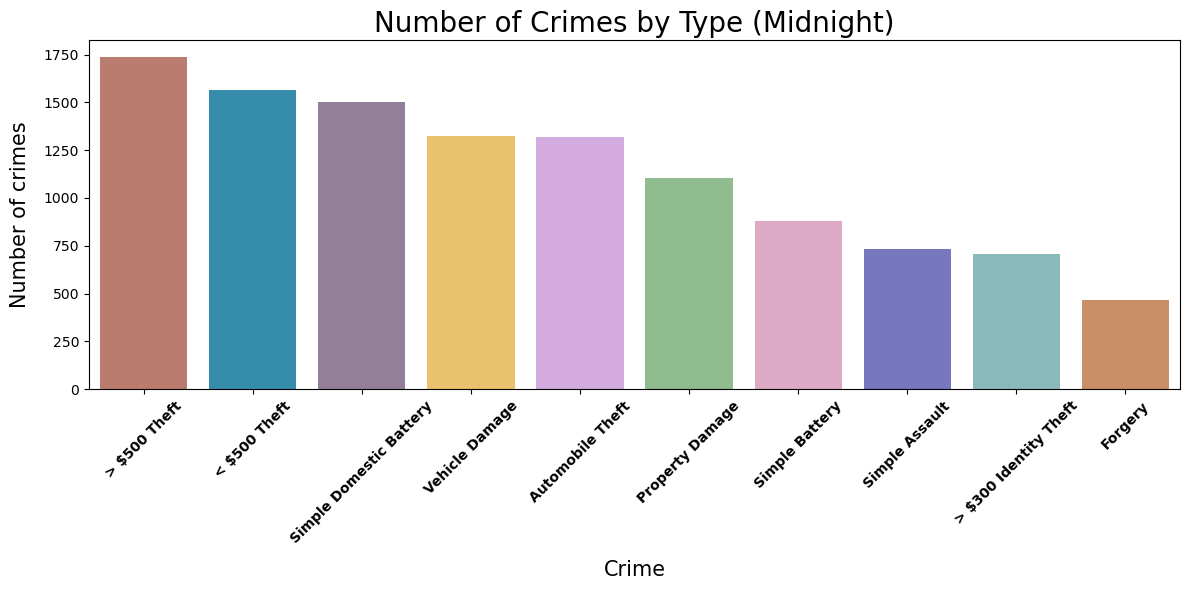

In [18]:
#| echo: false
midnight = time_data.loc[time_data['Date'].dt.hour == 0]
combination_midnight = midnight.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_midnight = combination_midnight.sort_values(by = 'Count', ascending = False).head(10)
combination_midnight['Type'] = combination_midnight['Primary Type'] + " " + combination_midnight['Description']
#barplot of crime types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_midnight.Type, y = combination_midnight.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Vehicle Damage', 
                             'Automobile Theft', 'Property Damage', 'Simple Battery', 'Simple Assault', 
                             '> $300 Identity Theft', 'Forgery'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Midnight)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
#plt.xticks(x, weight = 'bold')

plt.tight_layout()
plt.show()

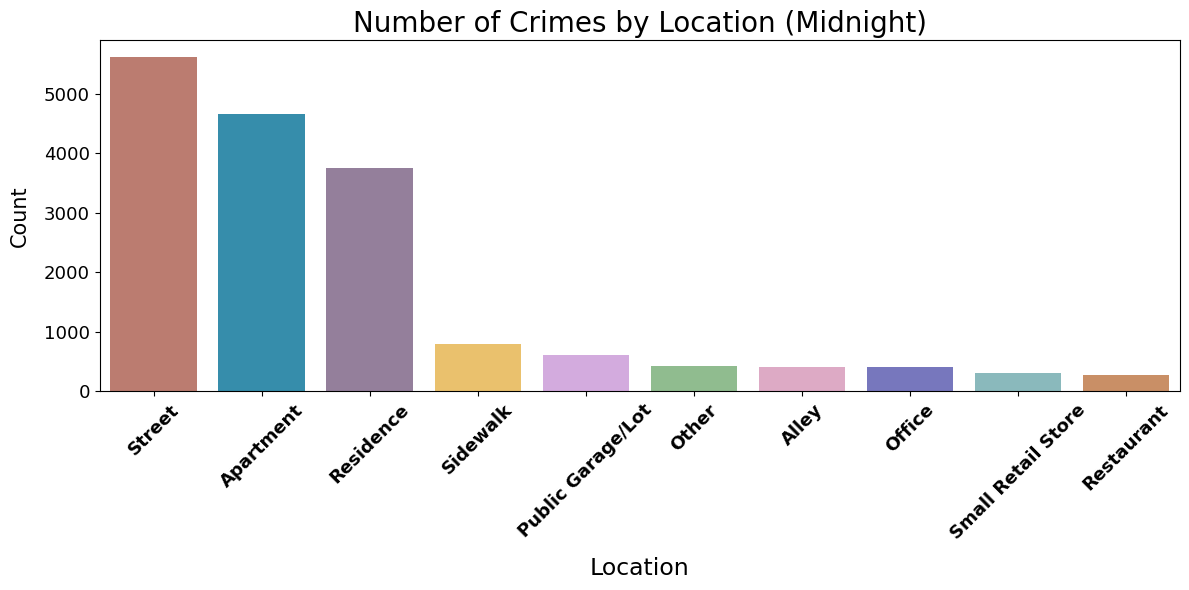

In [19]:
#| echo: false
midnight_locations = midnight['Location Description'].value_counts().head(10)
locations_midnight = midnight_locations.to_frame(name = 'Count').reset_index()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_midnight.index, y = locations_midnight.Count, palette = colors)
#ax = sns.barplot(x= locations_midnight.Count, y = locations_midnight.index, palette = colors, orient = "h")

plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Street', 'Apartment', 'Residence', 'Sidewalk', 
                            'Public Garage/Lot', 'Other', 'Alley', 'Office', 
                            'Small Retail Store', 'Restaurant'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Midnight)', fontsize = 20)
plt.xticks(rotation=45, weight = "bold", fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By \<Name of person doing the analysis>*

## Other sections

You are welcome to introduce additional sections or subsections, if required, to address your questions in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.